# **IMPORT LIBRARIES**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow albumentations opencv-python matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, load_model
import os
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, jaccard_score
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# **LOAD DATA**

In [ ]:
# Paths to the train folders
train_images_A_path = 'Downloads/building_change_train/A'
train_images_B_path = 'Downloads/building_change_train/B'
train_masks_path  = 'Downloads/building_change_train/label'

In [ ]:
# Paths to the validation folders
val_images_A_path = 'Downloads/building_change_val/A'
val_images_B_path = 'Downloads/building_change_val/B'
val_masks_path  = 'Downloads/building_change_val/label'

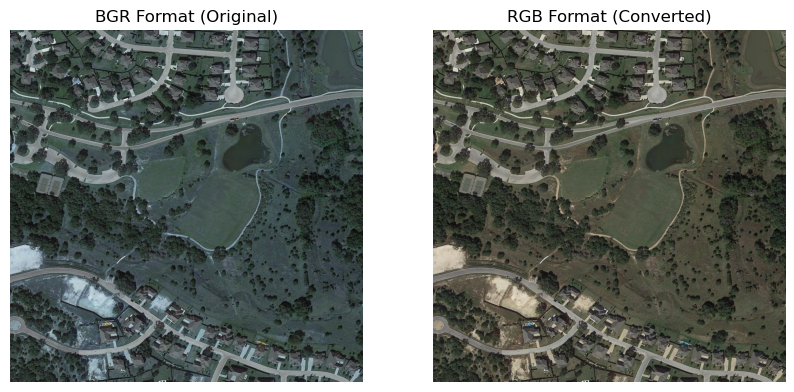

In [ ]:
image_path = 'Downloads/building_change_train/B/train_1.png'

# Load the image in BGR format
image_bgr = cv2.imread(image_path)

# Convert the BGR image to RGB format
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Display the images
plt.figure(figsize=(10, 5))

# Show the BGR image
plt.subplot(1, 2, 1)
plt.imshow(image_bgr)  # OpenCV default BGR will show incorrect colors in matplotlib
plt.title('BGR Format (Original)')
plt.axis('off')

# Show the RGB image
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)  # Correct RGB format
plt.title('RGB Format (Converted)')
plt.axis('off')

plt.show()

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return np.expand_dims(mask, axis=-1)  # Adding a channel dimension

def load_dataset(images_A_path, images_B_path, masks_path):
    images_A = []
    images_B = []
    masks = []
    image_names = os.listdir(images_A_path)

    for img_name in image_names:
        img_A = load_image(os.path.join(images_A_path, img_name))
        img_B = load_image(os.path.join(images_B_path, img_name))
        mask = load_mask(os.path.join(masks_path, img_name))

        images_A.append(img_A)
        images_B.append(img_B)
        masks.append(mask)

    return np.array(images_A), np.array(images_B), np.array(masks)

In [ ]:
# Load train dataset
images_A, images_B, masks = load_dataset(train_images_A_path, train_images_B_path, train_masks_path)

In [ ]:
# Load validation dataset
val_images_A, val_images_B, val_masks = load_dataset(val_images_A_path, val_images_B_path, val_masks_path)

In [ ]:
def convert_masks_to_npy(mask_dir, output_dir, image_size=(512,512)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for mask_file in os.listdir(mask_dir):
        if mask_file.endswith(".png"):
            # Load the mask and convert to binary if necessary
            mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
            mask_resized = cv2.resize(mask, image_size)
            mask = (mask_resized > 0).astype(np.float32)  # Convert to binary if needed

            # Save as npy file
            np.save(os.path.join(output_dir, mask_file.replace(".png", ".npy")), mask)

In [ ]:
# Directory to save train masks as npy
train_masks_npy = 'train_masks_npy_512'

# Create the directory if it doesn't exist
if not os.path.exists(train_masks_npy):
    os.makedirs(train_masks_npy)

# Directory to save validation masks as npy
val_masks_npy = 'val_masks_npy_512'

# Create the directory if it doesn't exist
if not os.path.exists(val_masks_npy):
    os.makedirs(val_masks_npy)

In [ ]:
convert_masks_to_npy(train_masks_path, train_masks_npy)

In [ ]:
convert_masks_to_npy(val_masks_path, val_masks_npy)

# **INSPECT NPY DATA**

In [ ]:
# Function to load images and masks from npy files
def load_npy_data(image_paths, mask_paths):
    images = [np.load(f"{image_paths}/{filename}") for filename in sorted(os.listdir(image_paths))]
    masks = [np.load(f"{mask_paths}/{filename}") for filename in sorted(os.listdir(mask_paths))]
    images = np.array(images)
    masks = np.array(masks)
    return images, masks

In [ ]:
# Load the training and validation data
train_images, train_masks = load_npy_data(output_dir, train_masks_npy)
val_images, val_masks = load_npy_data(val_output_dir, val_masks_npy)

In [ ]:
# Check the data shape
print("Training Images shape:", train_images.shape)
print("Training Masks shape:", train_masks.shape)
print("Validation Images shape:", val_images.shape)
print("Validation Masks shape:", val_masks.shape)

Training Images shape: (445, 512, 512, 6)
Training Masks shape: (445, 512, 512)
Validation Images shape: (64, 512, 512, 6)
Validation Masks shape: (64, 512, 512)


In [ ]:
print("Unique values in train mask:", np.unique(train_masks[0]))
print("Unique values in val mask:", np.unique(val_masks[0]))

# Check for proper binary mask values (should be 0 and 1)
assert train_masks[0].max() <= 1, "Masks should have binary values only (0 and 1)."
assert train_masks[0].min() >= 0, "Masks should have binary values only (0 and 1)."

Unique values in train mask: [0. 1.]
Unique values in val mask: [0. 1.]


In [ ]:
# Visualize a sample to ensure correctness
def visualize_sample(images, masks, index=0):
    plt.figure(figsize=(12, 4))

    # Plot the concatenated image (first 3 channels for before, last 3 for after)
    plt.subplot(1, 3, 1)
    plt.title("Before Image")
    plt.imshow(images[index][:, :, :3])  # Showing the first 3 channels for before image
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("After Image")
    plt.imshow(images[index][:, :, 3:])  # Showing the last 3 channels for after image
    plt.axis('off')

    # Plot the corresponding mask
    plt.subplot(1, 3, 3)
    plt.title("Mask")
    plt.imshow(masks[index].squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

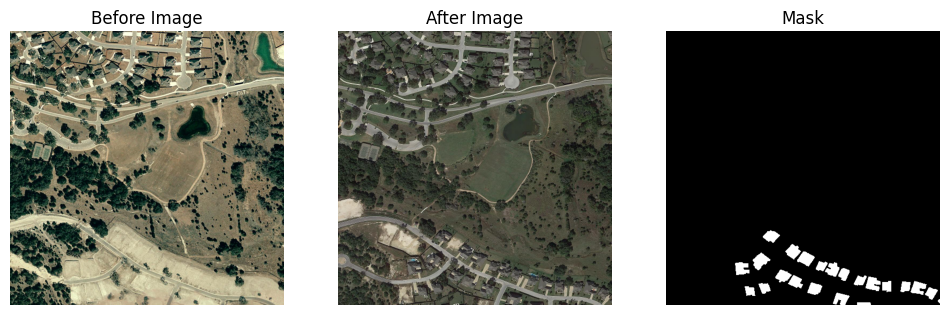

In [ ]:
# Visualize the first sample in training set
visualize_sample(train_images, train_masks, index=0)

In [ ]:
# Display few images in the train_images_A_path folder
def display_images_in(folder_path, num_images=5):
    image_files = os.listdir(folder_path)
    num_images = min(num_images, len(image_files))
    for i in range(num_images):
        image_path = os.path.join(folder_path, image_files[i])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

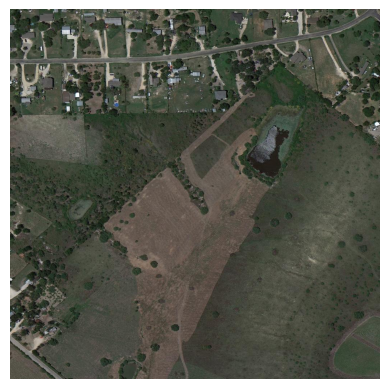

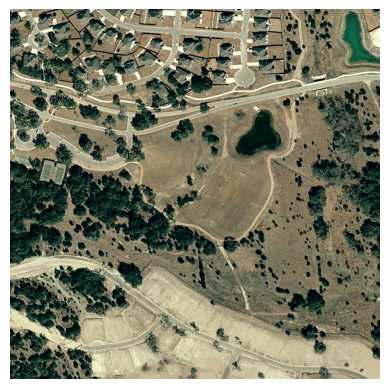

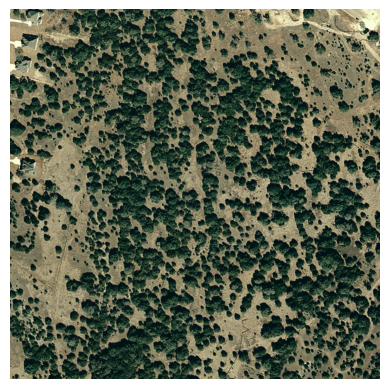

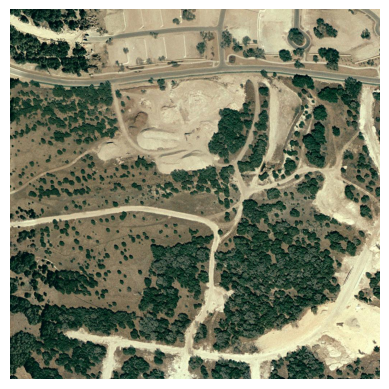

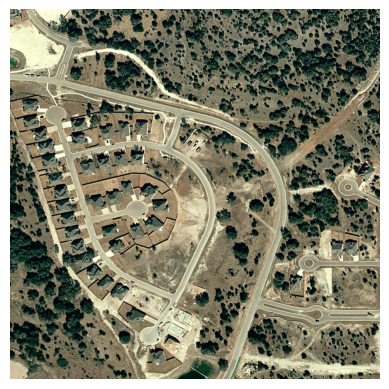

In [ ]:
display_images_in(train_images_A_path, num_images=5)

# **PREPROCESSING**

In [ ]:
def preprocess_images(images):
    return images / 255.0  # Normalizing

In [ ]:
images_A = preprocess_images(images_A)
images_B = preprocess_images(images_B)
masks = preprocess_images(masks)

In [ ]:
val_images_A = preprocess_images(val_images_A)
val_images_B = preprocess_images(val_images_B)
val_masks = preprocess_images(val_masks)

# **UNET MODEL SETUP**

In [ ]:
def unet_model(input_shape=(512, 512, 6)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = Model(inputs, outputs)

    return model

In [ ]:
# Build the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 6)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │          3,520 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512, 512, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 256)  │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 256)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 7,704,705 (29.39 MB)

 Trainable params: 7,701,889 (29.38 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
checkpoint = ModelCheckpoint("best_change_detect_model.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

# **CONCATENATE A+B**

In [ ]:
output_dir = "/content/drive/MyDrive/BuildingDetection/train_AB_512_rgb"
val_output_dir = "/content/drive/MyDrive/BuildingDetection/val_AB_512_rgb"
train_masks_npy = "/content/drive/MyDrive/BuildingDetection/train_masks_npy_512"
val_masks_npy = "/content/drive/MyDrive/BuildingDetection/val_masks_npy_512"

In [ ]:
images_A = images_A.astype(np.float32)
images_B = images_B.astype(np.float32)

In [ ]:
# Concatenate 'A' and 'B' images along the last axis to feed into the U-Net
train_images = np.concatenate([images_A, images_B], axis=-1)

In [ ]:
# Loop through each concatenated image and save it
for idx, concatenated_image in enumerate(train_images):
    # Define the output path (use corresponding filename or a numbered index)
    output_path = os.path.join(output_dir, f'trainAB_{idx+1}.jpg')

    # Convert concatenated image to the correct format if necessary (for example, uint8)
    concatenated_image = (concatenated_image * 255).astype(np.uint8)

    # Save the concatenated image using OpenCV
    cv2.imwrite(output_path, concatenated_image)

    print(f'Saved: {output_path}')

In [ ]:
# Convert masks to binary (if they aren't already)
train_masks = np.round(masks).astype(np.float32)

In [ ]:
val_images_A = val_images_A.astype(np.float32)
val_images_B = val_images_B.astype(np.float32)

In [ ]:
# Concatenate 'A' and 'B' images along the last axis to feed into the U-Net
val_images = np.concatenate([val_images_A, val_images_B], axis=-1)

In [ ]:
# Convert masks to binary (if they aren't already)
val_masks = np.round(val_masks).astype(np.float32)

# **MODEL TRAINING**

In [ ]:
EPOCHS = 10
BATCH_SIZE = 2

In [ ]:
def load_npy_data_in_batches(batch_size, images_dir, masks_dir):
    # List of all npy files in images and masks directories
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.npy')])
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.npy')])

    # Ensure the number of images and masks are the same
    assert len(image_files) == len(mask_files), "Mismatch between images and masks."

    # Batch processing
    for i in range(0, len(image_files), batch_size):
        # Load a batch of images and masks
        batch_images = [np.load(os.path.join(images_dir, img_file)) for img_file in image_files[i:i+batch_size]]
        batch_masks = [np.load(os.path.join(masks_dir, mask_file)) for mask_file in mask_files[i:i+batch_size]]

        # Stack to create batch
        batch_images = np.stack(batch_images)
        batch_masks = np.stack(batch_masks)

        yield batch_images, batch_masks

In [ ]:
def data_generator(batch_size, input_dir, mask_dir):
    input_files = sorted(os.listdir(input_dir))
    mask_files = sorted(os.listdir(mask_dir))
    while True:
        for i in range(0, len(input_files), batch_size):
            batch_input = []
            batch_mask = []
            for j in range(i, min(i + batch_size, len(input_files))):
                input_path = os.path.join(input_dir, input_files[j])
                mask_path = os.path.join(mask_dir, mask_files[j])

                # Load and preprocess the input and mask
                input_img = np.load(input_path)
                mask_img = np.load(mask_path)

                batch_input.append(input_img)
                batch_mask.append(mask_img)

            yield np.array(batch_input), np.array(batch_mask)

In [ ]:
# Usage with model.fit
train_gen = data_generator(BATCH_SIZE, output_dir, train_masks_npy)
val_gen = data_generator(BATCH_SIZE, val_output_dir, val_masks_npy)

In [ ]:
# Get a list of all .npy files in the training and validation directories
train_files = [f for f in os.listdir(output_dir) if f.endswith('.npy')]
val_files = [f for f in os.listdir(val_output_dir) if f.endswith('.npy')]

# Optionally sort the files to ensure correct pairing (useful if there are matching input-mask pairs)
train_files.sort()
val_files.sort()

In [ ]:
model.fit(train_gen, steps_per_epoch=len(train_files)//BATCH_SIZE,
          validation_data=val_gen, validation_steps=len(val_files)//BATCH_SIZE,
          epochs=EPOCHS, callbacks=[checkpoint, early_stopping])

Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.9312 - loss: 0.9963 - val_accuracy: 0.9547 - val_loss: 0.7294
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 124s 439ms/step - accuracy: 0.9383 - loss: 0.9945 - val_accuracy: 0.9547 - val_loss: 0.7294
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 97s 438ms/step - accuracy: 0.9384 - loss: 0.9933 - val_accuracy: 0.9547 - val_loss: 0.7294
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 97s 438ms/step - accuracy: 0.9385 - loss: 0.9906 - val_accuracy: 0.9547 - val_loss: 0.7294
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 97s 438ms/step - accuracy: 0.9387 - loss: 0.9881 - val_accuracy: 0.9547 - val_loss: 0.7294
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 97s 438ms/step - accuracy: 0.9379 - loss: 1.0009 - val_accuracy: 0.9547 - val_loss: 0.7294


In [ ]:
# Training loop
for train_images, train_masks in load_npy_data_in_batches(BATCH_SIZE, output_dir, train_masks_npy):
    model.fit(train_images, train_masks, batch_size=BATCH_SIZE, epochs=1, verbose=1, callbacks=[checkpoint, early_stopping])

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.9735 - loss: 0.4264


C:\Users\ekamb\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
C:\Users\ekamb\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9197 - loss: 1.2942
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.8901 - loss: 1.7716
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.9213 - loss: 1.2686
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.9282 - loss: 1.1574
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.9385 - loss: 0.9913
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.9245 - loss: 1.2163
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.9142 - loss: 1.3832
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.9715 - loss: 0.4596
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - accuracy: 0.8686 - loss: 2.1184
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - accuracy: 0.9434 - loss: 0.9118


In [ ]:
# Train the model
history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=4,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9427 - loss: 0.1871 - val_accuracy: 0.9501 - val_loss: 0.1273
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 137s 766ms/step - accuracy: 0.9648 - loss: 0.0939 - val_accuracy: 0.9155 - val_loss: 0.1851
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 85s 762ms/step - accuracy: 0.9692 - loss: 0.0835 - val_accuracy: 0.9313 - val_loss: 0.1445
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 143s 770ms/step - accuracy: 0.9724 - loss: 0.0735 - val_accuracy: 0.9625 - val_loss: 0.0903
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 87s 779ms/step - accuracy: 0.9714 - loss: 0.0751 - val_accuracy: 0.9744 - val_loss: 0.0757
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 141s 769ms/step - accuracy: 0.9764 - loss: 0.0655 - val_accuracy: 0.9744 - val_loss: 0.0688
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 141s 764ms/step - accuracy: 0.9763 - loss: 0.0633 - val_accuracy: 0.9565 - val_loss: 0.1683
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 144s 781ms/step - accuracy: 0.9783 - loss

# **SAVE THE MODEL**

In [ ]:
model.save('unet_building_change_detection.h5')

# **BATCH PROCESSING**

In [ ]:
batch_size = 10  # Adjust batch size based on available memory

In [ ]:
# Directory where you want to save the concatenated images
output_dir = 'train_AB_512_rgb'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# Directory where you want to save the concatenated images
val_output_dir = 'val_AB_512_rgb'

# Create the directory if it doesn't exist
if not os.path.exists(val_output_dir):
    os.makedirs(val_output_dir)

In [ ]:
def load_images_in_batches(path_A, path_B, batch_size):
    """
    Generator to yield batches of images from folders A and B.
    """
    images_A = sorted(os.listdir(path_A))
    images_B = sorted(os.listdir(path_B))
    num_images = len(images_A)

    for i in range(0, num_images, batch_size):
        batch_images_A = []
        batch_images_B = []

        for j in range(i, min(i + batch_size, num_images)):
            img_A = cv2.imread(os.path.join(path_A, images_A[j]), cv2.IMREAD_COLOR)
            img_B = cv2.imread(os.path.join(path_B, images_B[j]), cv2.IMREAD_COLOR)

            image_A_rgb = cv2.cvtColor(img_A, cv2.COLOR_BGR2RGB)
            image_B_rgb = cv2.cvtColor(img_B, cv2.COLOR_BGR2RGB)

            if image_A_rgb is not None and image_B_rgb is not None:
                batch_images_A.append(image_A_rgb)
                batch_images_B.append(image_B_rgb)

        yield batch_images_A, batch_images_B, images_A[i:i + batch_size]

In [ ]:
def process_and_save_batches_npy(path_A, path_B, output_dir, batch_size, image_size=(512, 512)):
    # Assume a function `load_images_in_batches` that yields batches of images A, B, and their names
    for batch_images_A, batch_images_B, image_names in load_images_in_batches(path_A, path_B, batch_size):
        for img_A, img_B, img_name in zip(batch_images_A, batch_images_B, image_names):
            # Resize the images to 512x512
            img_A_resized = cv2.resize(img_A, image_size)
            img_B_resized = cv2.resize(img_B, image_size)
            # Concatenate along the channel axis to create a 6-channel image
            concatenated_image = np.concatenate([img_A_resized, img_B_resized], axis=-1)

            # Define the save path and save as .npy
            output_path = os.path.join(output_dir, f'concatenated_{img_name}.npy')
            np.save(output_path, concatenated_image)
            print(f'Saved concatenated image: {output_path}')

In [ ]:
#Run batch processing
process_and_save_batches_npy(train_images_A_path, train_images_B_path, output_dir, batch_size)

Saved concatenated image: train_AB_512_rgb\concatenated_train_1.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_10.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_100.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_101.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_102.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_103.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_104.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_105.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_106.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_107.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_108.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_109.png.npy
Saved concatenated image: train_AB_512_rgb\concatenated_train_11.png.npy
Saved concatenated image: train_AB_512_rgb

In [ ]:
#Run batch processing
process_and_save_batches_npy(val_images_A_path, val_images_B_path, val_output_dir, batch_size)

Saved concatenated image: val_AB_512_rgb\concatenated_val_1.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_10.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_11.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_12.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_13.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_14.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_15.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_16.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_17.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_18.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_19.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_2.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_20.png.npy
Saved concatenated image: val_AB_512_rgb\concatenated_val_21.png.npy
Saved concatenated image: val_AB_512

# **PREDICTION VISUALISATION**

In [ ]:
def visualize_predictions(val_images, val_masks, model):
    predictions = model.predict(val_images)

    for i in range(len(predictions)):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 4, 1)
        plt.title("Before Image")
        plt.imshow(val_images[i, :, :, :3])  # Display first 3 channels (before image)

        # Display next 3 channels
        plt.subplot(1, 4, 2)
        plt.title("After Image")
        plt.imshow(val_images[i, :, :, 3:])

        plt.subplot(1, 4, 3)
        plt.title("Ground Truth")
        plt.imshow(val_masks[i].squeeze(), cmap='gray')

        plt.subplot(1, 4, 4)
        plt.title("Prediction")
        plt.imshow(predictions[i].squeeze(), cmap='gray')

        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


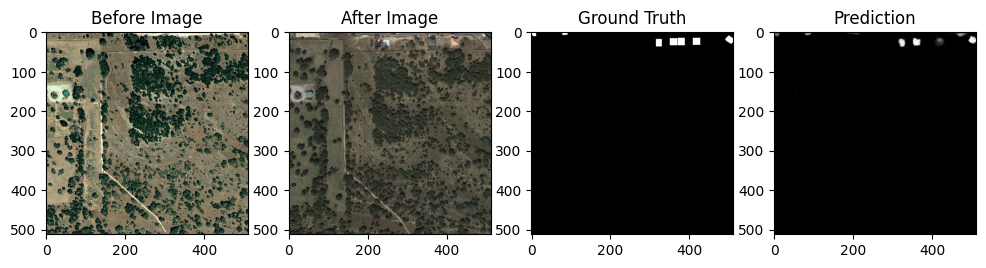

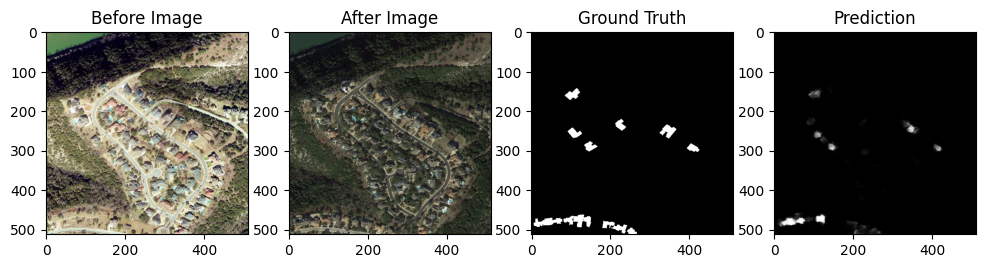

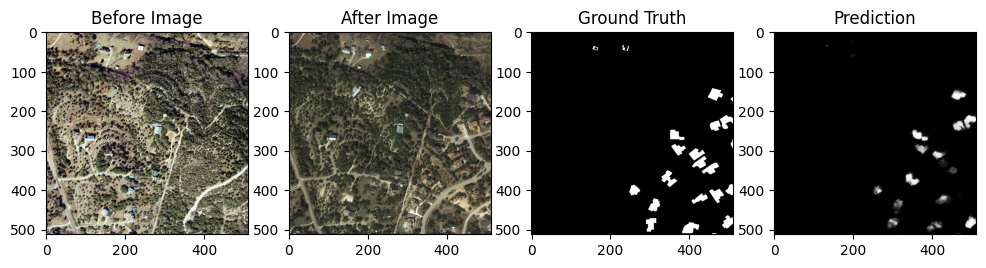

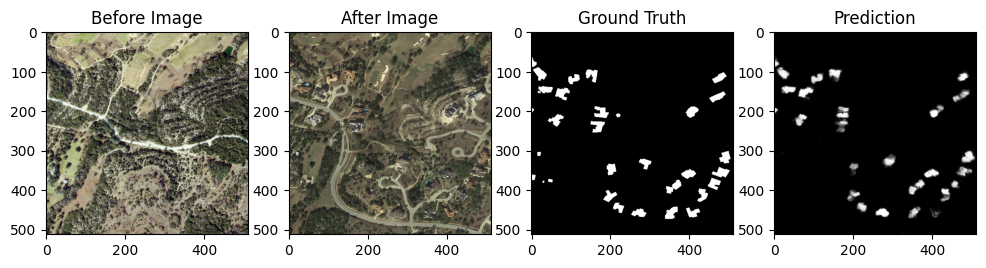

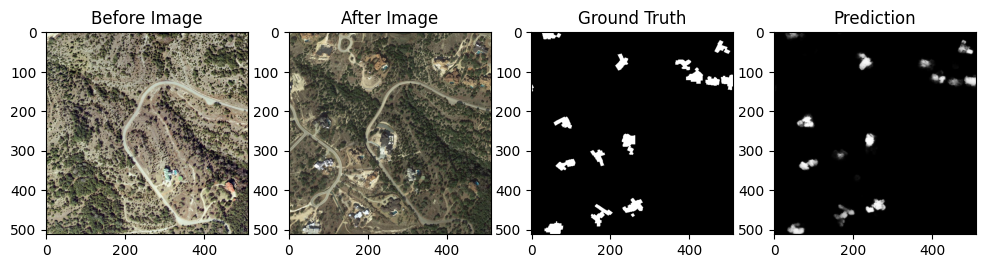

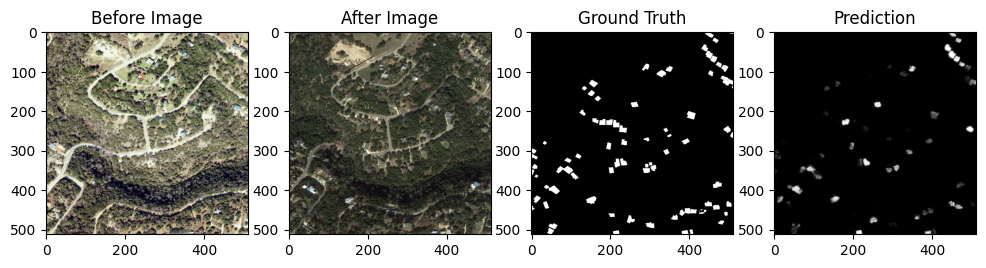

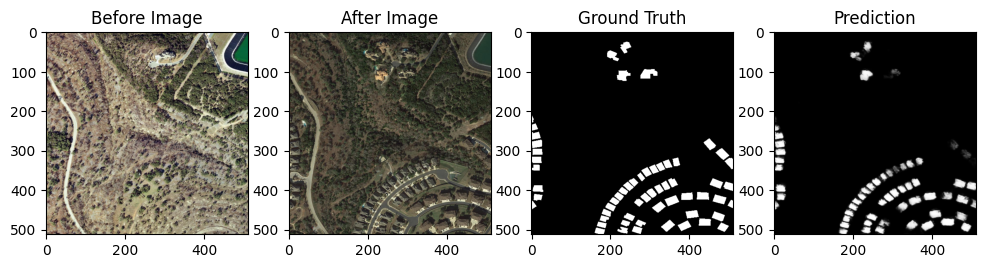

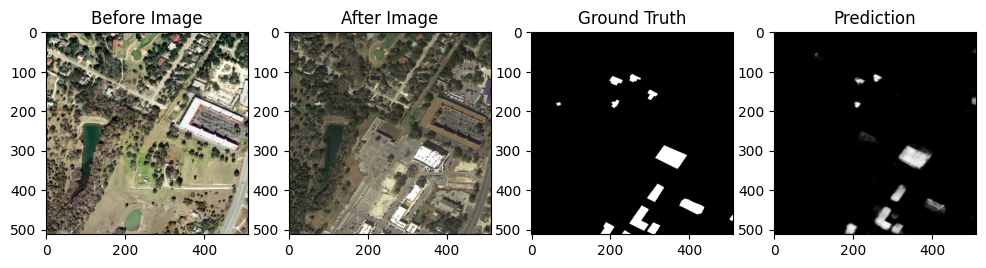

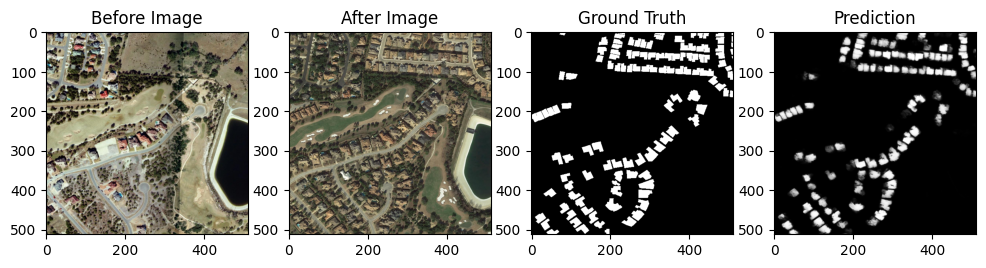

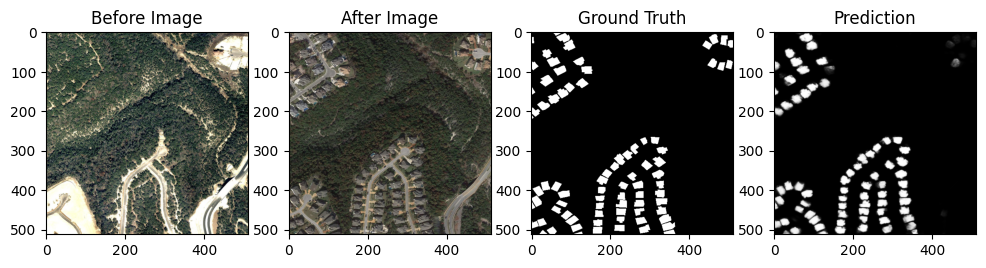

In [ ]:
# Load a sample batch of validation data for visualization
for val_images, val_masks in load_npy_data_in_batches(10, val_output_dir, val_masks_npy):
    visualize_predictions(val_images, val_masks, model)
    break